In [1]:
# Initialise the app
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('iteration4-data-mining').getOrCreate()

In [2]:
final_table = spark.read.csv('./final_table.csv', header='true')
final_table.show()

+------------------+--------------------+----------------+------+--------------+--------------------+----------------------------+
|collision_severity|            lighting|alcohol_involved|season|party_sobriety|       cellphone_use|movement_preceding_collision|
+------------------+--------------------+----------------+------+--------------+--------------------+----------------------------+
|             fatal|dark with street ...|           false|winter|             A|Cell Phone Not in...|            making left turn|
|             fatal|            daylight|            true|winter|             H|Cell Phone Not in...|                      parked|
|             fatal|            daylight|            true|winter|             C|Cell Phone Not in...|         proceeding straight|
|             fatal|            daylight|           false|winter|             A|Cell Phone Not in...|         proceeding straight|
|             fatal|            daylight|           false|winter|             G|Cel

In [3]:
from pyspark.sql.types import BooleanType
final_table = final_table.withColumn("alcohol_involved",final_table.alcohol_involved.cast(BooleanType()))

In [4]:
final_table.printSchema()

root
 |-- collision_severity: string (nullable = true)
 |-- lighting: string (nullable = true)
 |-- alcohol_involved: boolean (nullable = true)
 |-- season: string (nullable = true)
 |-- party_sobriety: string (nullable = true)
 |-- cellphone_use: string (nullable = true)
 |-- movement_preceding_collision: string (nullable = true)



In [5]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [6]:
#target variable
collision_severity_index = StringIndexer(inputCol='collision_severity', outputCol='collision_severity_index')
test = collision_severity_index.fit(final_table).transform(final_table)
test = test.drop('collision_severity')


#independent variables
lighting_index = StringIndexer(inputCol='lighting', outputCol='lighting_index')
lighting_encoder = OneHotEncoder(inputCol='lighting_index', outputCol='lighting_vec')

season_index = StringIndexer(inputCol='season', outputCol='season_index')
season_encoder = OneHotEncoder(inputCol='season_index', outputCol='season_vec')

party_sobriety_index = StringIndexer(inputCol='party_sobriety', outputCol='party_sobriety_index')
party_sobriety_encoder = OneHotEncoder(inputCol='party_sobriety_index', outputCol='party_sobriety_vec')

cellphone_use_index = StringIndexer(inputCol='cellphone_use', outputCol='cellphone_use_index')
cellphone_use_encoder = OneHotEncoder(inputCol='cellphone_use_index', outputCol='cellphone_use_vec')

movement_preceding_collision_index = StringIndexer(inputCol='movement_preceding_collision', outputCol='movement_preceding_collision_index')
movement_preceding_collision_encoder = OneHotEncoder(inputCol='movement_preceding_collision_index', outputCol='movement_preceding_collision_vec')


In [7]:
assembler = VectorAssembler(inputCols=[
 'lighting_vec',
 'season_vec',
 'party_sobriety_vec',
'cellphone_use_vec', 
'movement_preceding_collision_vec'],outputCol='features')

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
log_reg_collision = LogisticRegression(featuresCol='features',labelCol='collision_severity_index')

In [9]:
pipeline = Pipeline(stages = [lighting_index, season_index, party_sobriety_index,
                            cellphone_use_index, movement_preceding_collision_index,
                           lighting_encoder, season_encoder,party_sobriety_encoder,
                            cellphone_use_encoder, movement_preceding_collision_encoder, 
                            assembler, log_reg_collision])

In [10]:
train_data, test_data = test.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 100917
Test Dataset Count: 25191


In [11]:
fit_model = pipeline.fit(train_data)

In [12]:
# Transform test data. 
results = fit_model.transform(test_data)

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="collision_severity_index", predictionCol="prediction", metricName="accuracy")

In [14]:
results.select('collision_severity_index','prediction').show()

+------------------------+----------+
|collision_severity_index|prediction|
+------------------------+----------+
|                     1.0|       1.0|
|                     2.0|       1.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
|                     0.0|       0.0|
+------------------------+----------+
only showing top 20 rows



In [15]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = acc_evaluator.evaluate(results)

AUC

0.6427295462665238

In [16]:
totalResults = results.select('collision_severity_index','prediction')

correctResults = totalResults.filter(totalResults['collision_severity_index'] == totalResults['prediction'])

wrongResults = totalResults.filter(totalResults['collision_severity_index'] != totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC))

countTW = wrongResults.count()
print("Total Wrong: " + str(countTW))

ratioCorrect = countTC / countTR
print("Correct Ratio: " + str(ratioCorrect))

ratioWrong = countTW / countTR
print("Wrong Ratio: " + str(ratioWrong))

Correct: 25191
Total Correct: 16191
Total Wrong: 9000
Correct Ratio: 0.6427295462665238
Wrong Ratio: 0.35727045373347627


Text(0.5,1,'collision_severity_index vs prediction with one-hot')

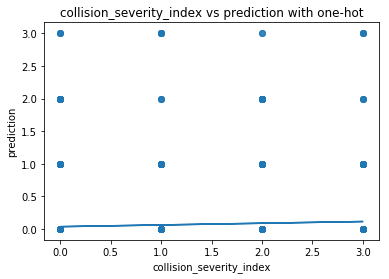

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

result_pandas=results.toPandas()
plt.scatter(result_pandas['collision_severity_index'], result_pandas['prediction'],cmap='viridis',alpha=0.3);
m, b = np.polyfit(result_pandas['collision_severity_index'], result_pandas['prediction'], 1)
plt.plot(result_pandas['collision_severity_index'], m*result_pandas['collision_severity_index'] + b)
plt.xlabel('collision_severity_index') 
plt.ylabel('prediction') 
plt.title("collision_severity_index vs prediction with one-hot")

In [20]:
pipeline2 = Pipeline(stages = [lighting_index, season_index, party_sobriety_index,
                            cellphone_use_index, movement_preceding_collision_index,
                           lighting_encoder, season_encoder,party_sobriety_encoder,
                            cellphone_use_encoder, movement_preceding_collision_encoder, 
                            assembler, log_reg_collision])

In [21]:
train_data2, test_data2 = test.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data2.count()))
print("Test Dataset Count: " + str(test_data2.count()))

Training Dataset Count: 100790
Test Dataset Count: 25318


In [22]:
fit_model2 = pipeline2.fit(train_data)
results2 = fit_model2.transform(test_data)

Text(0.5,1,'collision_severity_index vs prediction without one-hot')

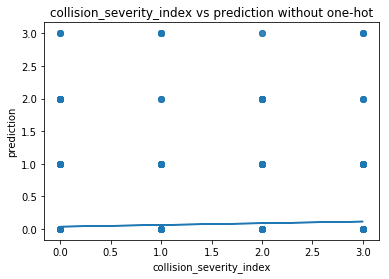

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

result_pandas2=results2.toPandas()
plt.scatter(result_pandas2['collision_severity_index'], result_pandas2['prediction'],cmap='viridis',alpha=0.3);
m, b = np.polyfit(result_pandas2['collision_severity_index'], result_pandas2['prediction'], 1)
plt.plot(result_pandas2['collision_severity_index'], m*result_pandas2['collision_severity_index'] + b)
plt.xlabel('collision_severity_index') 
plt.ylabel('prediction') 
plt.title("collision_severity_index vs prediction without one-hot")